# Analysis of a Heart Disease Prediction Dataset

Cet ensemble de données provient du [Kaggle Heart Disease dataset](https://www.kaggle.com/datasets/mfarhaannazirkhan/heart-dataset) et contient des informations sur les caractéristiques médicales des patients pour prédire la présence ou l'absence d'une maladie cardiaque.
L’objectif principal du jeu de données est de créer un modèle prédictif capable d’identifier les patients à risque de développer une maladie cardiaque en fonction de plusieurs facteurs de santé.

Avant de s'attaquer au code, il est important d'analyser les données pour comprendre les informations qu'elles contiennent. Voici les informations concernant les colonnes de ce dataset :

- **age**: Âge du patient (Numérique).
- **sex**: Sexe du patient. Valeurs : 1 = homme, 0 = femme.
- **cp**: Type de douleur thoracique. Valeurs : 0 = Angine typique, 1 = Angine atypique, 2 = Douleur non angineuse, 3 = Asymptomatique.
- **trestbps**: Pression artérielle au repos (en mm Hg) (Numérique).
- **chol**: Niveau de cholestérol sérique (en mg/dl) (Numérique).
- **fbs**: Glycémie à jeun > 120 mg/dl. Valeurs : 1 = vrai, 0 = faux.
- **restecg**: Résultats de l'électrocardiogramme au repos. Valeurs : 0 = Normal, 1 = Anomalie de l'onde ST-T, 2 = Hypertrophie ventriculaire gauche.
- **thalach**: Fréquence cardiaque maximale atteinte (Numérique).
- **exang**: Angine induite par l'exercice. Valeurs : 1 = oui, 0 = non.
- **oldpeak**: Dépression du segment ST induite par l'exercice par rapport au repos (Numérique).
- **slope**: Pente du segment ST au pic de l'exercice. Valeurs : 0 = Ascendante, 1 = Plate, 2 = Descendante.
- **ca**: Nombre de vaisseaux majeurs (0-3) colorés par fluoroscopie. Valeurs : 0, 1, 2, 3.
- **thal**: Types de thalassémie. Valeurs : 1 = Normal, 2 = Défaut fixe, 3 = Défaut réversible.
- **target**: Variable de résultat (risque de crise cardiaque). Valeurs : 1 = plus de risque de crise cardiaque, 0 = moins de risque de crise cardiaque.

## Prerequis & informations

In [1]:
%load_ext autoreload
%autoreload 2

import sys
import os

# Get the path to the project root
project_root = os.path.abspath(os.path.join(os.getcwd(), "../"))
src_path = os.path.join(project_root, "src")

# Add the src path to the python path
sys.path.append(src_path)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import preprocessing
import model as mdl
import utils

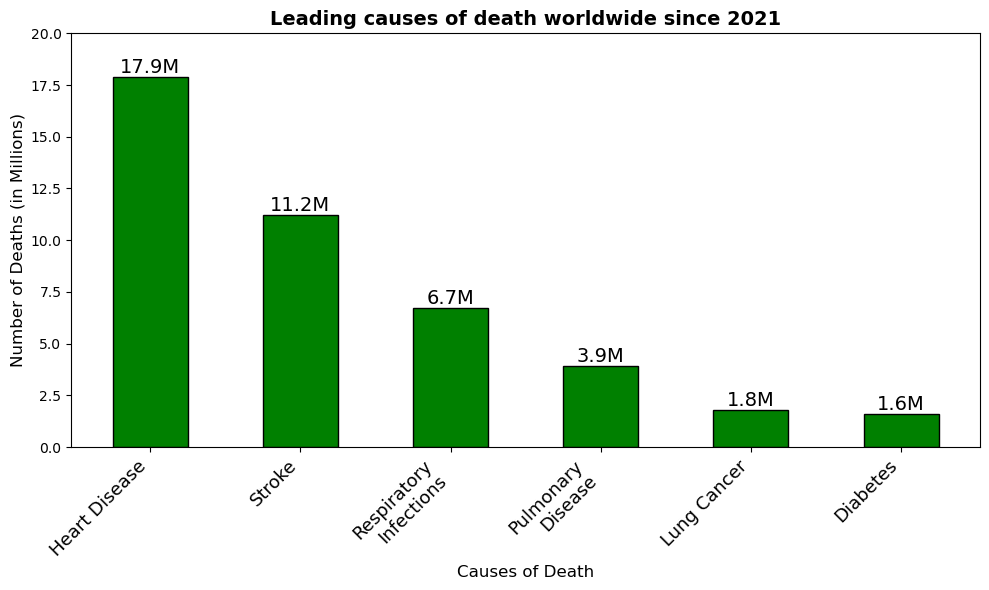

In [3]:
causes = [
    "Heart Disease", "Stroke", "Respiratory\nInfections",
    "Pulmonary\nDisease", "Lung Cancer", 
    "Diabetes"
]
deaths = [17.9, 11.2, 6.7, 3.9, 1.8, 1.6]  # in millions
plt.figure(figsize=(10, 6))
bars = plt.bar(causes, deaths, color='green', edgecolor='black', width=0.5)
for bar in bars:
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 0.2,
        f"{bar.get_height()}M",
        ha='center',
        fontsize=14
    )
plt.title("Leading causes of death worldwide since 2021", fontsize=14, weight='bold')
plt.ylabel("Number of Deaths (in Millions)", fontsize=12)
plt.xlabel("Causes of Death", fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=13)
plt.ylim(0, 20)
plt.tight_layout()
plt.show()

Ce barplot illustre l'évolution des maladies cardiaques enregistrées jusqu'à présent. Elle permet de voir l'importance de la maladie cardiaque dans le monde et de l'enjeu de la prévention.

##  Data preprocessing

In [4]:
data = preprocessing.load_data("../data/raw_merged_heart_dataset.csv")
categorial_cols = ['target']
data.describe(include='all')
print(data.shape)

(2181, 14)


Les données comporte des variables de type objets. C'est surement pour cette raison que les différentes unités statistiques ne sont pas affichées. Il est donc nécessaire de les convertir en variables numériques pour pouvoir les utiliser pour notre modèle.

### Identifying missing values

En analysant en profondeur nos données, nous pouvons voir que nous n'avons pas de valeurs manquantes dans notre dataset représenté par des caracteres '?'.

In [5]:
col_na = []
for col in data.columns:
    if data[col].astype(str).str.contains(r'\?').any():
        col_na.append(col)
print(col_na)

['trestbps', 'chol', 'fbs', 'restecg', 'thalachh', 'exang', 'slope', 'ca', 'thal']


In [6]:
data = preprocessing.handle_missing_values(data)
data.dtypes

age               int64
sex               int64
cp                int64
trestbps        float64
chol            float64
fbs             float64
restecg         float64
thalachh        float64
exang           float64
oldpeak         float64
slope           float64
ca              float64
thal            float64
target            int64
has_trestbps      int64
has_chol          int64
has_fbs           int64
has_restecg       int64
has_thalachh      int64
has_exang         int64
has_slope         int64
has_ca            int64
has_thal          int64
dtype: object

In [7]:
data.describe(include='all')

,age,sex,cp,trestbps,chol,fbs,restecg,thalachh,exang,oldpeak,...,target,has_trestbps,has_chol,has_fbs,has_restecg,has_thalachh,has_exang,has_slope,has_ca,has_thal
count,2181.000000,2181.000000,2181.000000,2181.000000,2181.00000,2181.000000,2181.000000,2181.000000,2181.000000,2181.000000,...,2181.000000,2181.0,2181.0,2181.0,2181.0,2181.0,2181.0,2181.0,2181.0,2181.0
mean,53.477762,0.693260,1.507565,131.679046,247.30995,0.137552,0.546538,148.065566,0.327373,0.990509,...,0.496103,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
std,9.194787,0.461246,1.371587,17.561495,53.61256,0.344508,0.631195,23.320972,0.469362,1.141851,...,0.500099,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,28.000000,0.000000,0.000000,92.000000,85.00000,0.000000,0.000000,71.000000,0.000000,0.000000,...,0.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
25%,46.000000,0.000000,0.000000,120.000000,211.00000,0.000000,0.000000,132.000000,0.000000,0.000000,...,0.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
50%,54.000000,1.000000,2.000000,130.000000,242.00000,0.000000,0.000000,151.000000,0.000000,0.600000,...,0.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
75%,60.000000,1.000000,2.000000,140.000000,276.00000,0.000000,1.000000,165.000000,1.000000,1.600000,...,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
max,77.000000,1.000000,4.000000,200.000000,603.00000,1.000000,2.000000,202.000000,1.000000,6.200000,...,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


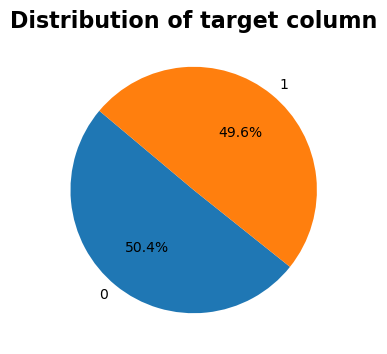

In [8]:
utils.plot_pie_chart(data, 'target')

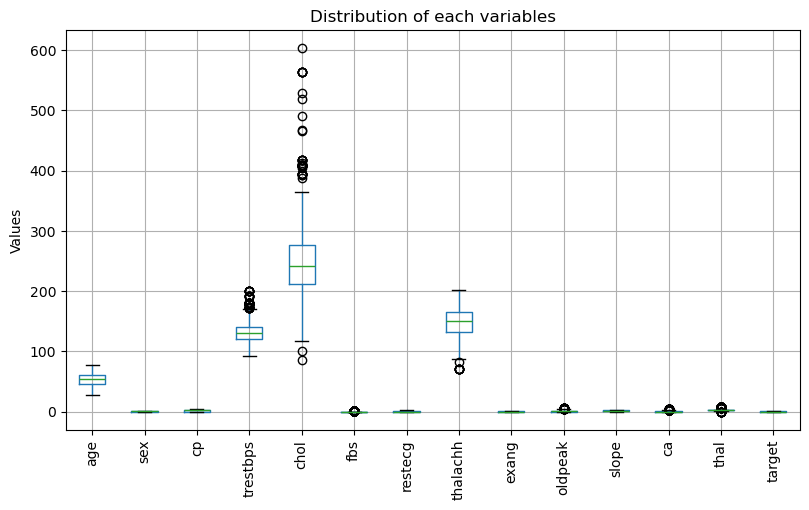

In [9]:
# Select descriptives variables without has_varible
data_filtered = data.filter(regex='^(?!.*has)')
utils.plot_boxplots(data_filtered, "Distribution of each variables")

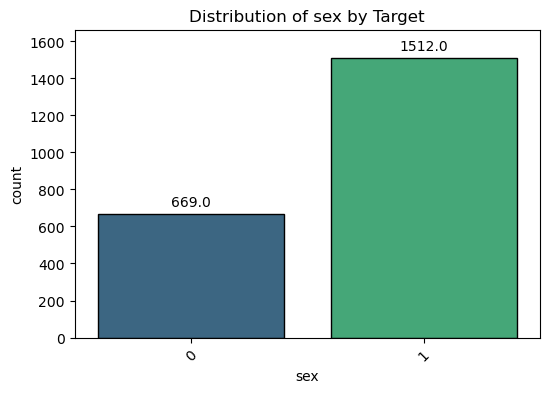

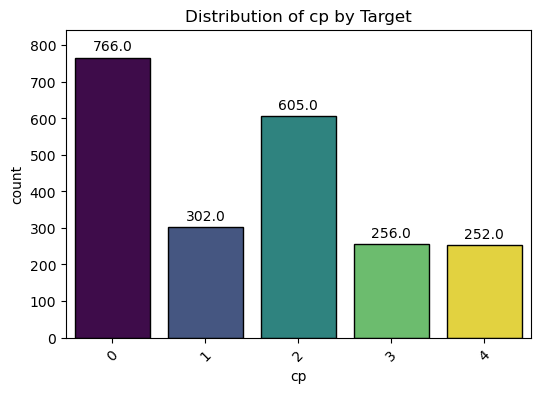

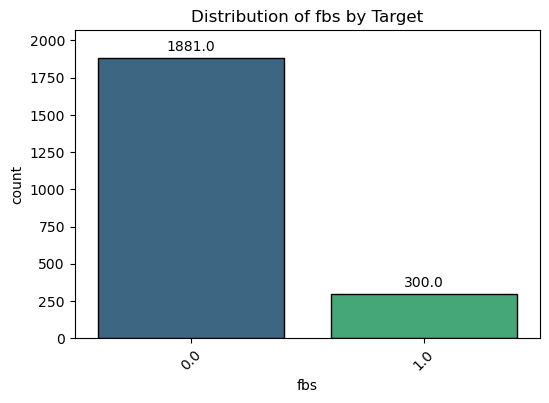

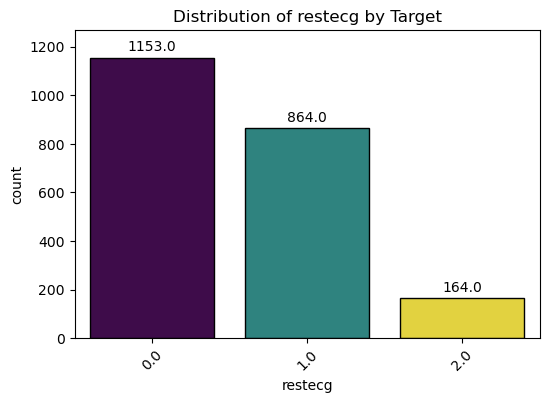

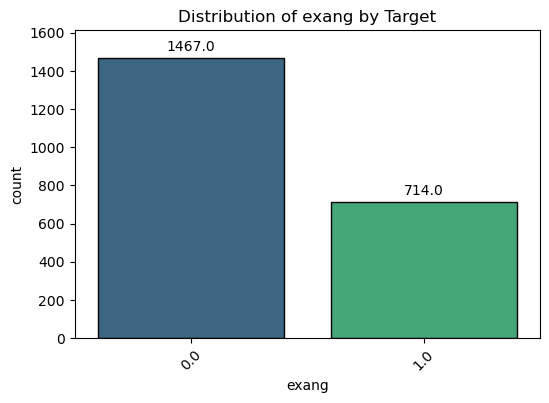

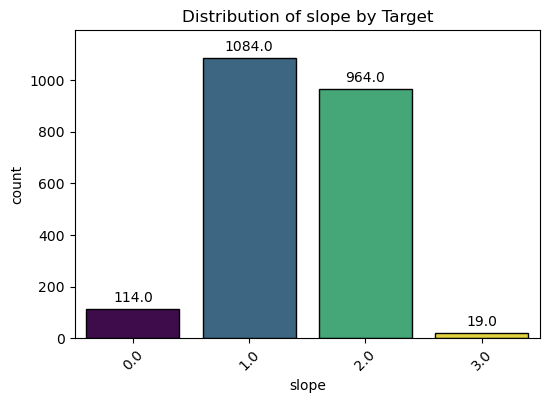

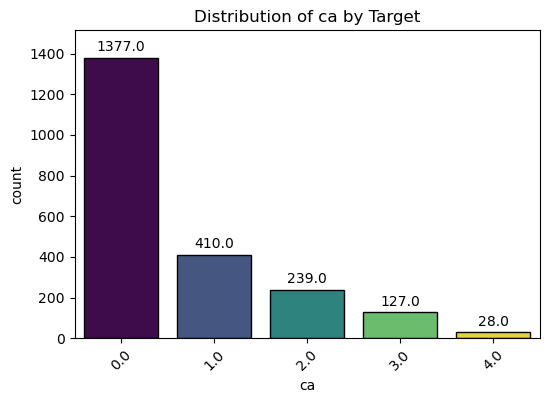

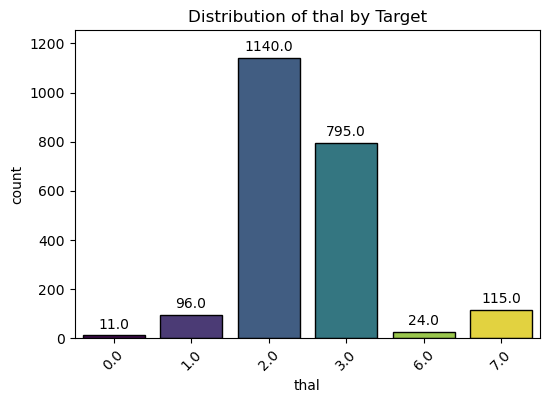

In [10]:
categorical_cols = preprocessing.get_columns(data_filtered, 'categorical')
for col in categorical_cols:
    utils.plot_barplot(data_filtered, col, title=f'Distribution of {col} by Target')

<h3>Categorical variables encoding</h3>

<h4>One-hot Encoding</h4>

In [11]:
categorial_cols = preprocessing.get_columns(data, 'categorical')
to_encode = [col for col in categorial_cols if 'has' not in col]
data = pd.get_dummies(data, columns=to_encode, drop_first=True, dtype='int')
data.dtypes

age               int64
trestbps        float64
chol            float64
thalachh        float64
oldpeak         float64
target            int64
has_trestbps      int64
has_chol          int64
has_fbs           int64
has_restecg       int64
has_thalachh      int64
has_exang         int64
has_slope         int64
has_ca            int64
has_thal          int64
sex_1             int64
cp_1              int64
cp_2              int64
cp_3              int64
cp_4              int64
fbs_1.0           int64
restecg_1.0       int64
restecg_2.0       int64
exang_1.0         int64
slope_1.0         int64
slope_2.0         int64
slope_3.0         int64
ca_1.0            int64
ca_2.0            int64
ca_3.0            int64
ca_4.0            int64
thal_1.0          int64
thal_2.0          int64
thal_3.0          int64
thal_6.0          int64
thal_7.0          int64
dtype: object

## Correlation matrix

Une fois que les données manquants ont été traitées et que les variables catégorielles ont été encodées, nous pouvons maintenant examiner la corrélation entre les différentes variables de notre ensemble de données.

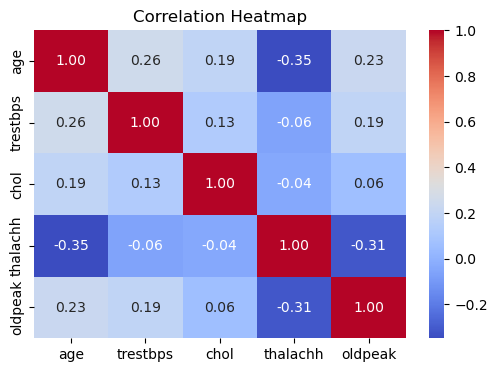

In [12]:
numeric_col = preprocessing.get_columns(data, 'numeric')
utils.plot_correlation_heatmap(data[numeric_col], "Correlation Heatmap")

Grace à la matrice de corrélation, nous pouvons voir les relations entre les différentes variables de notre dataset. Les valeurs de la matrice de corrélation varient de -1 à 1. Une valeur de 1 signifie une corrélation positive parfaite, -1 signifie une corrélation négative parfaite et 0 signifie qu'il n'y a pas de corrélation entre les variables. Dans notre cas, nous pouvons qu'il n'y a pas de colinéarité entre les variables puisque les valeurs sont proches de 0. On suppose donc que les variables sont indépendantes les unes des autres.

## Normalizing the data

Certains des modèles telques la regression logisitque sont sensibles à l'échelle des variables. Il est donc important de normaliser les données pour que les variables soient à la même échelle.

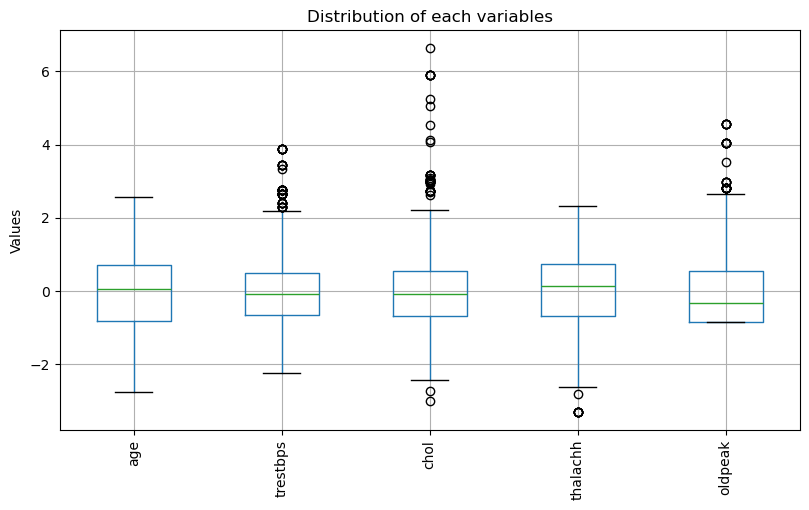

In [13]:
data_normalized = preprocessing.normalize_data(data)
numeric_columns = preprocessing.get_columns(data_normalized, 'numeric')
utils.plot_boxplots(data[numeric_columns], "Distribution of each variables")

## Model Building

In [14]:
print(data.shape)
data.head()

(2181, 36)


,age,trestbps,chol,thalachh,oldpeak,target,has_trestbps,has_chol,has_fbs,has_restecg,...,slope_3.0,ca_1.0,ca_2.0,ca_3.0,ca_4.0,thal_1.0,thal_2.0,thal_3.0,thal_6.0,thal_7.0
0,1.035850,0.758706,-0.266975,0.082967,1.147078,1,1,1,1,1,...,0,0,0,0,0,1,0,0,0,0
1,-1.792487,-0.095631,0.050187,1.669886,2.198244,1,1,1,1,1,...,0,0,0,0,0,0,1,0,0,0
2,-1.357359,-0.095631,-0.808017,1.026541,0.358703,1,1,1,1,1,...,0,0,0,0,0,0,1,0,0,0
3,0.274375,-0.665190,-0.211005,1.283879,-0.166881,1,1,1,1,1,...,0,0,0,0,0,0,1,0,0,0
4,0.383157,-0.665190,1.990476,0.640533,-0.342075,1,1,1,1,1,...,0,0,0,0,0,0,1,0,0,0


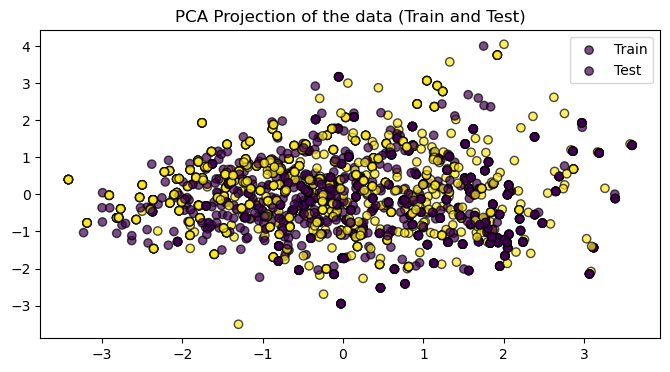

In [15]:
train_x_norm, test_x_norm, train_y_norm, test_y_norm = mdl.split_data(data_normalized, 'target')
train_x, test_x, train_y, test_y = mdl.split_data(data, 'target')
utils.plot_pca(train_x_norm, test_x_norm, train_y_norm, test_y_norm)

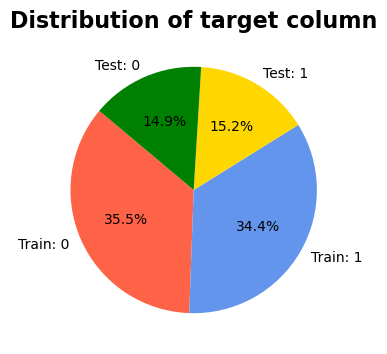

In [16]:
display_train_y = train_y_norm.apply(lambda x: f'Train: {x}')
display_test_y = test_y_norm.apply(lambda x: f'Test: {x}')
combined = pd.concat([display_train_y, display_test_y], axis=1)
combined.columns = ['target_train', 'target_test']
combined['target'] = combined['target_train'].combine_first(combined['target_test'])
combined = combined.drop(columns=['target_train', 'target_test'])
colors=['tomato', 'cornflowerblue', 'gold', 'green']
utils.plot_pie_chart(combined, 'target', colors)

Nous avons testé sur un split de donnée et avec une validation croisée. Elle permet de s'assurer que les performances ne dépendent pas uniquement d'une division particulière des données.

### Logistic Regression, KNN & SVM

In [17]:
model = mdl.create_classifier("logistic")
model.fit(train_x_norm, train_y_norm)
scores = mdl.eval_disease_classifier(test_x_norm, test_y_norm, model)
print(pd.DataFrame(scores, index=["score"]))
scores = mdl.cross_validation(train_x_norm, train_y_norm, model)
print(pd.DataFrame(scores).head(2))

       accuracy  precision    recall        f1
score   0.79084    0.78869  0.800604  0.794603
      accuracy precision    recall        f1   roc_auc
mean  0.775238   0.76303  0.789554  0.775309  0.861053
std   0.029441  0.031442  0.047085  0.031969  0.025591


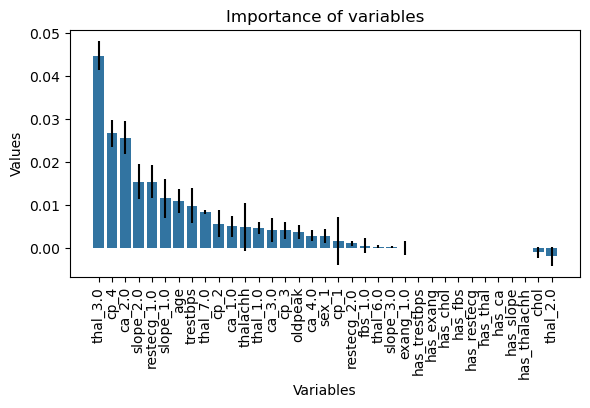

In [18]:
error_permutation = mdl.permutation_features(train_x_norm, train_y_norm, model, n_shuffle=5)
importances = pd.DataFrame({
    'mean': error_permutation.importances_mean,
    'std': error_permutation.importances_std
}, index=train_x.columns)
importances = importances.sort_values(by="mean", ascending=False)
utils.plot_importances(importances, "Importance of variables")

In [19]:
best_k = mdl.find_best_k(train_x_norm, train_y_norm)
print(f"Best k: {best_k}")
model = mdl.create_classifier("knn", best_k)
model.fit(train_x_norm, train_y_norm)
scores = mdl.eval_disease_classifier(test_x_norm, test_y_norm, model)
print(pd.DataFrame(scores, index=["score"]))
scores = mdl.cross_validation(train_x_norm, train_y_norm, model)
print(pd.DataFrame(scores).head(2))

Best k: 1
       accuracy  precision    recall        f1
score  0.940458   0.939759  0.942598  0.941176
      accuracy precision    recall        f1   roc_auc
mean  0.912195  0.913367  0.908132  0.910428  0.912131
std    0.01438  0.016985  0.027418  0.015511  0.014495


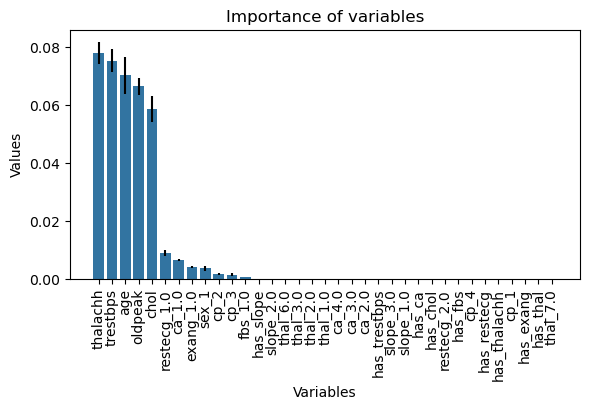

In [20]:
error_permutation = mdl.permutation_features(train_x_norm, train_y_norm, model, n_shuffle=5)
importances = pd.DataFrame({
    'mean': error_permutation.importances_mean,
    'std': error_permutation.importances_std
}, index=train_x.columns)
importances = importances.sort_values(by="mean", ascending=False)
utils.plot_importances(importances, "Importance of variables")

In [21]:
model = mdl.create_classifier("svm")
model.fit(train_x_norm, train_y_norm)
scores = mdl.eval_disease_classifier(test_x_norm, test_y_norm, model)
print(pd.DataFrame(scores, index=["score"]))
print("\nCross validation")
scores = mdl.cross_validation(train_x_norm, train_y_norm, model)
print(pd.DataFrame(scores).head(2))

       accuracy  precision    recall        f1
score  0.848855   0.853659  0.845921  0.849772

Cross validation
      accuracy precision    recall        f1   roc_auc
mean   0.82767  0.831656  0.816238  0.823447  0.910348
std   0.024108  0.031792   0.02851  0.023694  0.019021


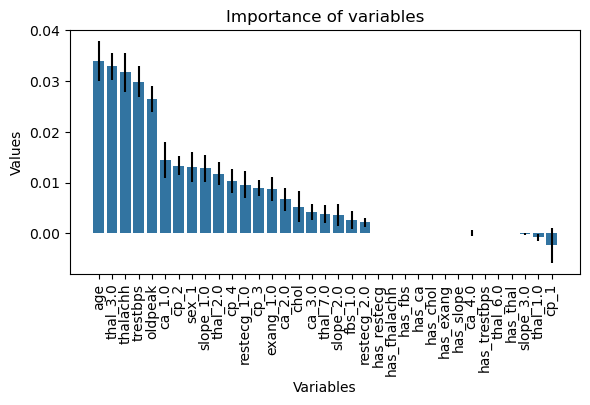

In [22]:
error_permutation = mdl.permutation_features(train_x_norm, train_y_norm, model, n_shuffle=5)
importances = pd.DataFrame({
    'mean': error_permutation.importances_mean,
    'std': error_permutation.importances_std
}, index=train_x.columns)
importances = importances.sort_values(by="mean", ascending=False)
utils.plot_importances(importances, "Importance of variables")

### Decision tree & random forest

In [23]:
model = mdl.create_classifier("decision_tree")
model.fit(train_x, train_y)
scores = mdl.eval_disease_classifier(test_x, test_y, model)
print(pd.DataFrame(scores, index=["score"]))
scores = mdl.cross_validation(train_x, train_y, model)
print("\nCross validation")
print(pd.DataFrame(scores).head(2))

       accuracy  precision    recall        f1
score  0.934351   0.918605  0.954683  0.936296

Cross validation
      accuracy precision    recall        f1   roc_auc
mean  0.902364  0.900504  0.900132  0.901951  0.906315
std   0.014688  0.012515  0.022313   0.01446  0.017817


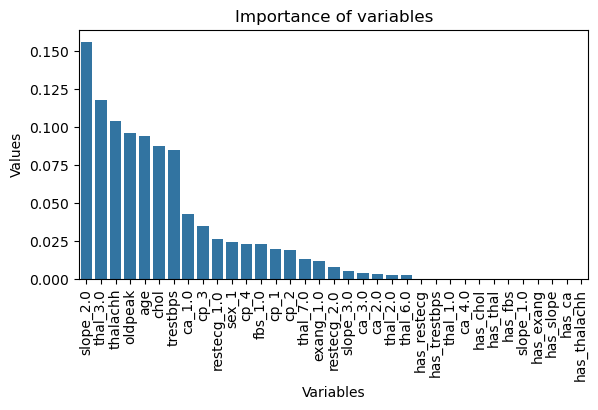

In [24]:
importances = pd.Series(model.feature_importances_, index=train_x.columns)
importances = importances.sort_values(ascending=False)
utils.plot_importances(importances, "Importance of variables")

In [25]:
model = mdl.create_classifier("random_forest")
model.fit(train_x, train_y)
scores = mdl.eval_disease_classifier(test_x, test_y, model)
print(pd.DataFrame(scores, index=["score"]))
scores = mdl.cross_validation(train_x, train_y, model)
print("\nCross validation")
print(pd.DataFrame(scores).head(2))

       accuracy  precision    recall        f1
score  0.954198   0.949254  0.960725  0.954955

Cross validation
      accuracy precision    recall        f1   roc_auc
mean  0.931855  0.934387  0.921439  0.926975  0.985307
std   0.013302  0.018857  0.014228  0.010603  0.003421


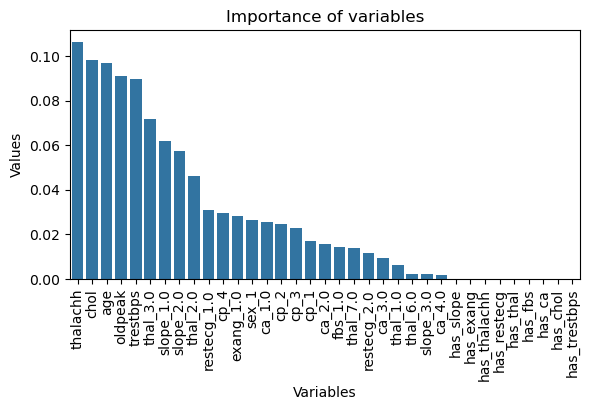

In [26]:
importances = pd.Series(model.feature_importances_, index=train_x.columns)
importances = importances.sort_values(ascending=False)
utils.plot_importances(importances, "Importance of variables")

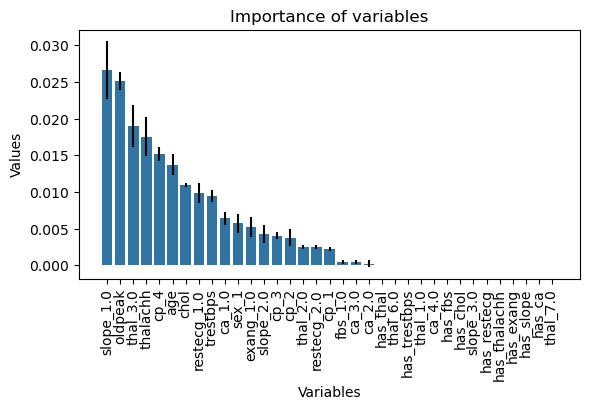

In [27]:
error_permutation = mdl.permutation_features(train_x_norm, train_y_norm, model, n_shuffle=5)
importances = pd.DataFrame({
    'mean': error_permutation.importances_mean,
    'std': error_permutation.importances_std
}, index=train_x.columns)
importances = importances.sort_values(by="mean", ascending=False)
utils.plot_importances(importances, "Importance of variables")

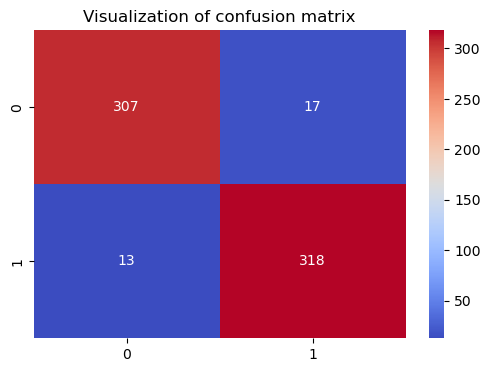

In [28]:
y_pred = model.predict(test_x)
utils.plot_confusion_matrix(test_y, y_pred, "Visualization of confusion matrix")

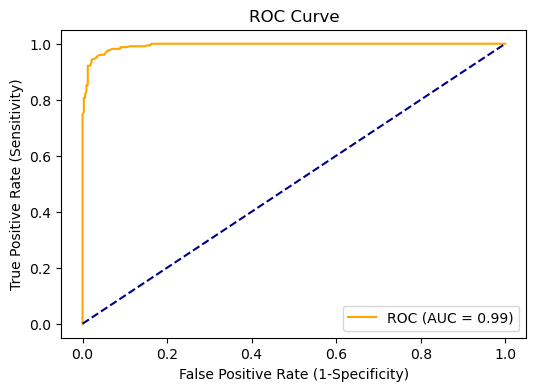

In [29]:
y_pred_proba = model.predict_proba(test_x)[:, 1] # Probability of 1 (heart disease present)
fpr, tpr, threshold, auc = mdl.get_roc_metrics(test_y, y_pred_proba)
utils.plot_roc_curve(fpr, tpr, auc)

## Annexes

/tmp/ipykernel_12408/1077258108.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = data_filtered.groupby('age_group').mean()


                  age    trestbps        chol    thalachh   oldpeak
age_group                                                          
young       33.417910  124.865672  217.029851  170.582090  0.465672
middle age  47.576957  128.041337  242.464380  152.214600  0.778364
old         61.720573  136.379734  255.025589  141.692938  1.273388


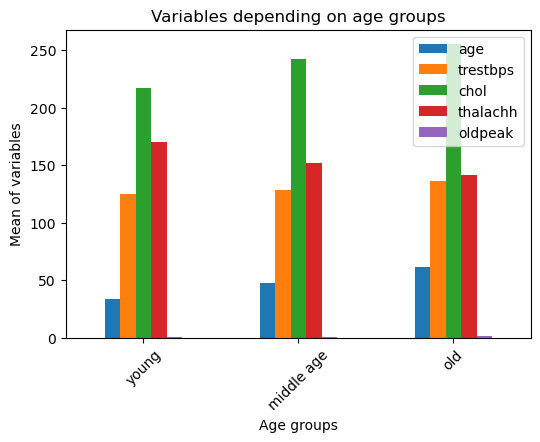

In [30]:
bins = [0, 35, 55, 100]
labels = ['young', 'middle age', 'old']
data_filtered['age_group'] = pd.cut(data_filtered['age'], bins=bins, labels=labels)
numeric_cols = preprocessing.get_columns(data_filtered, 'numerical')
grouped = data_filtered.groupby('age_group').mean()
grouped = grouped[numeric_cols]
print(grouped)

grouped.plot(kind='bar', figsize=(6, 4))
plt.title('Variables depending on age groups')
plt.xlabel('Age groups')
plt.ylabel('Mean of variables')
plt.xticks(rotation=45)
plt.show()